In [1]:
import numpy as np
from rw import lazy_handler
import matplotlib.pyplot as plt

# RenShape

**RenShape** is a tool for evaluating the antineutrino spectrum from reactors using the summation method.

The data for evaluating the total antineutrino spectrum are taken from various databases: 
- cumulative fission yields from JEFF
- decay data from ENDF-B sub-library and ENSDF
- Q-values from ENSDF

A new database is created by merging all the relevant information into a single file. To evaluate the neutrino spectra, the decay data are processed with **BetaShape**. The resulting database (HDF5 file format) is manteined and updated periodically. The latest version (October 2024) is called "verza.lazy". 

You can find all the data used to create this file, along with the database itself, on the following link:

You may choose to create your own database using RenShape by launching the script *createLazyFile.py* (see instruction in RenShape/scripts/README.md), or you can simply use the precompiled file available on Zenodo.

### How is compiled

The dataset is populated by following these steps (as outlined in scripts/createLazy.py):

1) The nuclides with cumulative fission yields (cfy) greater than zero are recorded. The cfy are taken from JEFF.

2) For these nuclides, the Q value (and half life) are written. The data are taken from ENSDF.

3) For these nuclides, their neutrino spectra is evaluated using data from ENDF/B sub-library:

*In the ENDF/B sub-library, the available data for a nuclide can be of type "discrete" or "continuum". If former, all the information needed for evaluating the neutrino spectrum is present (end-point energies, transition types, intensity...). If "continuum" only the electron(neutrino) spectrum from a CGM calculation is reported.\
If the data are "discreet", the neutrino spectra for the nuclide is evaluated using BetaShape. If "continuum", the spectrum is saved as-is, but the nuclide is tagged accordingly. Due to the missing information, please treat the "continuum" data cum grano salis.*

4) Beta-decaying nuclides not present in the ENDF/B sub-library are processed with BetaShape using available data from ENSDF. Additionally, "continuum" nuclides are re-processed with BetaShape if data are available in the ENSDF database. In this case, the original "continuum" spectrum is saved as a backup (*dN_dE_tot_c*).
    

### File structure

The .lazy file is organized as follows: 

In the *header*, you will find general information about the file. After that, all the nuclides are listed.

Each nuclide has its own *data* block, which contains the output from BetaShape, including the
binned neutrino spectrum for each transition, the total spectrum, and more. 
- **transition_Emax:** ndarray with the maximum energy in keV for the transitions
- **transition_intensity:** ndarray with the intensity of the transition
- **transition_dN_dE:** ndarray with the transition spectra. The i-th row corresponds to the i-th entry of the arrays
- **transition_unc_dN_dE:** ndarray with the uncertanties associated with the spectra
- **transition_unc_intensity:** ndarray with the uncertanties associated with the intensity of the levels in shorthand notation (sorry).
- **dN_dE_tot:** ndarray with the full electron(neutrino) spectrum
- **unc_dN_dE** ndarray with the uncertanty associated with dN_dE_tot
- **transition_type:** ndarray with type of transition. "a" for allowed, "1u" for first-forbidden unique, "1nu" for first-forbidden non-unique, and so on.
- **dN_dE_tot_c:** present only if the spectrum is evaluated with a CGM evaluation and not with BetaShape. If an ENSDF file was found related to that nuclide, dN_dE_tot will be different from dN_dE_tot_c. See "How is compiled"

In the *info* block, you can find all the information not related to BetaShape, such as the cumulative fission yield for the selected nuclide.
- **Q:** Q-value in keV. Taken from ENSDF
- **unc_Q:** Q-value uncertainty 
- **cumulative_fast_fy_#:** cumulative fast fission yield for #, taken from JEFF
- **cumulative_thermal_fy_#:** cumulative thermal fission yield for #, taken from JEFF
- **unc_cf_#:** uncertainty  for cumulative fast of #
- **unc_ct_#:** uncertainty  for cumulative thermal of #
- **n:** number of neutrons
- **z:** atomic number
- **m:** metastable state. 0 is normal, 1 is the first metastable and so on
- **half_life_sec:** half-life in sec, taken from ENSDF
- **Emax:** present only if the nuclide was processed by BetaShape. Is the neutrino endpoint energy in keV.
- **tag:** present only if the nuclide was processed by BetaShape. It tells you where the information for the total neutrino spectrum (dN_dE_tot) was taken. endf_b -> ENDF/B sublibrary. endf_b_c -> ENDF/B sublibrary, without BetaShape (spectrum from a CGM calculation). ensdf -> ENSDF
- **lazy_name:** name of the nuclide

# RenShape reader

In [2]:
path = "" # path for the .lazy file

reader =lazy_handler.LazyReader(path)

In [3]:
# You can get the file header containing some usefull information as a dictionary
# Betashape_options are the option used in betashape to process all the spectra
# E_step is the energy step (in keV) for all calculated spectra
header = reader.get_info()
header

{'Betashape_options': 'myEstep=1 nu=1',
 'Betashape_version': '2.4',
 'E_step': 1.0,
 'JEFF_release': '3.3',
 'Release_date': 'oct 2024'}

In [4]:
# To get nuclides name present in the database as a list
# *_1m is the first metastable state, and so on.
nuclides_name = reader.get_nuclides_list()

for i in range(20):
    print(nuclides_name[i])

100Mo
100Nb
100Nb_1m
100Rb
100Ru
100Sr
100Tc
100Y
100Y_1m
100Zr
101Mo
101Nb
101Rb
101Ru
101Sr
101Tc
101Y
101Zr
102Mo
102Nb


In [7]:
# To get a single nuclide information as a python dictionary, you can use it's name

nuclide = reader.get_nuclide(name="100Nb")

# Or you can use specify it's position in the file
print("Position of the 100Nb:", np.where(np.array(nuclides_name)=="100Nb")[0][0])

#nuclide = reader.get_nuclide(loc=1) # gives the same output

for key, value in nuclide.items():
    print(key , ":",value)

Position of the 100Nb: 1
Emax : 6381.0
Q : 6396.0
cumulative_fast_fy_235u : 0.05632
cumulative_fast_fy_238u : 0.063256
cumulative_fast_fy_241Pu : 0.053776
cumulative_thermal_fy_235u : 0.055398
cumulative_thermal_fy_239Pu : 0.050055
cumulative_thermal_fy_241Pu : 0.060989
half_life_sec : 1.4
m : 0.0
n : 59.0
tag : endf_b
unc_Q : 0.8
unc_cf_235u : 0.0025637
unc_cf_238u : 0.0039918
unc_cf_241Pu : 0.001626
unc_ct_235u : 0.0010397
unc_ct_239Pu : 0.0015307
unc_ct_241Pu : 0.004034
z : 41.0
dN_dE_tot : [0.00000000e+00 1.87019393e-10 6.24190040e-10 ... 1.17794000e-05
 1.17441000e-05 1.17089000e-05]
transition_Emax : [3446. 5845. 4061. 4343. 4295. 4774. 3377. 3342. 3411. 4191. 4404. 4917.
 6381. 5686. 5245. 3318. 3251. 3311. 4876. 5317.]
transition_dN_dE : [[0.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.68531e-11 5.51738e-11 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 5.02934e-12 1.74081e-11 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 

In [8]:
# To see the parameters names for each nuclide
reader.get_parameters_labels()

['Emax',
 'Q',
 'cumulative_fast_fy_235u',
 'cumulative_fast_fy_238u',
 'cumulative_fast_fy_241Pu',
 'cumulative_thermal_fy_235u',
 'cumulative_thermal_fy_239Pu',
 'cumulative_thermal_fy_241Pu',
 'half_life_sec',
 'm',
 'n',
 'tag',
 'unc_Q',
 'unc_cf_235u',
 'unc_cf_238u',
 'unc_cf_241Pu',
 'unc_ct_235u',
 'unc_ct_239Pu',
 'unc_ct_241Pu',
 'z']

In [9]:
# To get the value of the selected parameter (e.g. Emax) for all the nuclides in the dataset as a numpy array
# If the parameter is not found for a given nuclides, *variable_not_found* is used instead

Emax = reader.get_parameters("Emax",variable_not_found = -1)


In [10]:
#=============================================
# Example: print the name of all the nuclides name with a Q-value greater than 12e3 keV
#=============================================
Qs = reader.get_parameters("Q")
index = np.where(Qs>=12e3)[0]
print( np.array(nuclides_name)[index] )

['100Rb' '106Y' '110Nb' '116Tc' '128Ag' '12B' '130Ag' '131Cd' '131In_2m'
 '132Cd' '132In' '54Sc' '60V' '62V' '65Cr' '66Mn' '68Mn' '70Co' '70Co_1m'
 '72Co' '73Co' '74Co' '77Ni' '78Cu' '82Ga' '84Ga' '84Ga_1m' '85Ga' '8Li'
 '92Br' '98Rb' '98Rb_1m' '9Li']


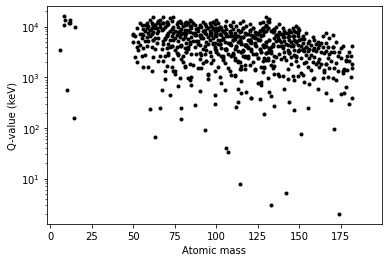

In [11]:
#=============================================
# Example: plot the Q value vs mass number for all the nuclide in the dataset
#=============================================
Qs = reader.get_parameters("Q")
z = reader.get_parameters("z")
n = reader.get_parameters("n")


a = z + n

plt.plot(a,Qs,'.',c='k')
plt.yscale("log")
plt.xlim(-2)
plt.xlabel("Atomic mass")
plt.ylabel("Q-value (keV)")
plt.show()

In [41]:
# Return the neutrino spectra of the nuclides in the dataset with their uncertanties
# Keep in mind that not all the nuclide in the dataset will have an associated neutrino spectra.
# See "how is compiled" for more details.
# Read the helper for additional information (reader.get_nu_spectra?)
energy, spectra, spectra_er, posOK, posnotOK = reader.get_nu_spectra(E_min =0 , E_max = 10e3)

In [42]:
#=============================================
# Example: print the first 6 names of nuclides which do not have an associated neutrino spectrum
#=============================================
print("There are",posnotOK.shape[0]," nuclides without a neutrino spectra")
print("The first 6 are:")
for el in np.array(nuclides_name)[posnotOK[:6]]:
    print(el)

There are 351  nuclides without a neutrino spectra
The first 6 are:
100Mo
100Ru
101Ru
102Ru
103Rh
103Rh_1m


In [43]:
# Return the neutrino spectrum from reactors given certain fission fractions
# Read the helper for additional information (reader.get_total_spectrum?)
ff235 = 0.5
ff239 = 0.2
ff241 = 0.2
ff238 = 0.1


ffs = [ff235,ff239,ff241,ff238]
labels=["cumulative_thermal_fy_235u","cumulative_thermal_fy_239Pu","cumulative_thermal_fy_241Pu","cumulative_fast_fy_238u"]
labels_unc=["unc_ct_235u","unc_ct_239Pu","unc_ct_241Pu","unc_cf_238u"]


spectrum_tot, spectrum_tot_er = reader.get_total_spectrum(labels = labels, labels_unc = labels_unc,
                                                          ffs = ffs, ffs_unc = None, do_sum = True,
                                                          spectra=spectra,spectra_er=spectra_er,posOK=posOK)

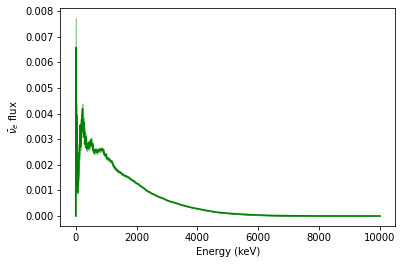

In [44]:
plt.plot(energy,spectrum_tot,c='g')
plt.fill_between(energy,spectrum_tot,spectrum_tot+spectrum_tot_er,color='g',alpha=0.4)
plt.fill_between(energy,spectrum_tot,spectrum_tot-spectrum_tot_er,color='g',alpha=0.4)

plt.xlabel("Energy (keV)")
plt.ylabel(r"$\bar{\nu}_e$ flux")
plt.show()

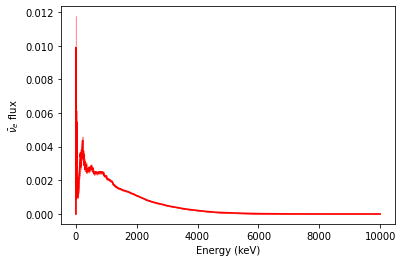

In [45]:
#=============================================
# Example: plot the neutrino flux from Pu239
#=============================================

spectrum_tot, spectrum_tot_er = reader.get_total_spectrum(labels = ["cumulative_thermal_fy_239Pu"], 
                                                          labels_unc = ["unc_ct_239Pu"],
                                                          ffs = [1], ffs_unc = None, do_sum = True,
                                                          spectra=spectra,spectra_er=spectra_er,posOK=posOK)

plt.plot(energy,spectrum_tot,c='r')
plt.fill_between(energy,spectrum_tot,spectrum_tot+spectrum_tot_er,color='r',alpha=0.4)
plt.fill_between(energy,spectrum_tot,spectrum_tot-spectrum_tot_er,color='r',alpha=0.4)

plt.xlabel("Energy (keV)")
plt.ylabel(r"$\bar{\nu}_e$ flux")
plt.show()

# RenShape writer

In [48]:
path = "" #path for the .lazy file

writer =lazy_handler.LazyWriter(fname=path)

For all writer methods, if a variable already exists, it will be redefined.

In [ ]:
# Add information on the file header as a python dictionary
writer.set_general_info({"random_name":0.2})

In [ ]:
# Add a parameter to a given nuclide. If the nuclide does not exist, it will be added to the dataset.
# For adding a parameter to the info block as a dictionary...
writer.write_nuclide_data(nuclide_name="100Xy",dtype="info", dictionary={"random_name":2,"dummy_variable":"bello"})
# or as a variable...
writer.write_nuclide_data(nuclide_name="100Xy",dtype="info", vname = "dummy",vvalue=12)


# You can add a parameter to the data block instead by replecing dytpe = "info" with dytpe = "data"

# Exercises

To get familiar with RenShape, the following exercises are suggested. They are listed in increasing order of difficulty:

    - Plot the Q vs atomic mass for the nuclides w/o an associated spectrum.
    - Plot the neutrino spectrum of 235U using the continuum spectra for 100Rb instead of the one from ENSDF.
    - Try to recreate a plot similar the one in notebook/ex.pdf